In [1]:
%load_ext autoreload
%autoreload 2
import os
os.chdir('..')

In [2]:
import networkx as nx
import torch
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torch.nn.functional as F
import numpy as np
import scipy.sparse
import matplotlib.pyplot as plt
from nn_homology import nn_graph
from archs.mnist.AlexNet import AlexNet

import persim # see persim.scikit-tda.org
from ripser import ripser # see ripser.scikit-tda.org

To generate the model used in this example, I ran:

`python main.py --arch_type alexnet --dataset mnist --prune_percent 95 --prune_iterations 2 --end_iter 30`

In [3]:
# Global-like variable definitions.
model_name = 'alexnet'
dataset_name = 'mnist'
data_location = '../data' # location of training data (MNIST, FashionMNIST, CIFAR, etc.)
msk_pct = 95 # prune percentage for LT network
model_loc0 = 'saves/{}/{}/0_model_lt.pth.tar'.format(model_name, dataset_name) # location of saved, un-pruned model 
model_loc1 = 'saves/{}/{}/1_model_lt.pth.tar'.format(model_name, dataset_name) # location of saved, pruned model (after 1 prune iteration)

## Unpruned Model Homology

In [4]:
# load the model.
model = torch.load(model_loc0)
alnt = AlexNet()
print(alnt.param_info)

/home/schraterlab/anaconda3/lib/python3.8/site-packages/torch/serialization.py:593: SourceChangeWarning: source code of class 'torch.nn.modules.container.Sequential' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


[{'layer_type': 'Conv2d', 'kernel_size': (3, 3), 'stride': 2, 'padding': 2, 'name': 'Conv1'}, {'layer_type': 'MaxPool2d', 'kernel_size': (3, 3), 'stride': 2, 'padding': 0, 'name': 'MaxPool1'}, {'layer_type': 'Conv2d', 'kernel_size': (5, 5), 'stride': 1, 'padding': 2, 'name': 'Conv2'}, {'layer_type': 'MaxPool2d', 'kernel_size': (3, 3), 'stride': 2, 'padding': 0, 'name': 'MaxPool2'}, {'layer_type': 'Conv2d', 'kernel_size': (3, 3), 'stride': 1, 'padding': 1, 'name': 'Conv3'}, {'layer_type': 'Conv2d', 'kernel_size': (3, 3), 'stride': 1, 'padding': 1, 'name': 'Conv4'}, {'layer_type': 'Conv2d', 'kernel_size': (3, 3), 'stride': 1, 'padding': 1, 'name': 'Conv5'}, {'layer_type': 'MaxPool2d', 'kernel_size': (3, 3), 'stride': 2, 'padding': 0, 'name': 'MaxPool3'}, {'layer_type': 'Linear', 'name': 'Linear1'}, {'layer_type': 'Linear', 'name': 'Linear2'}, {'layer_type': 'Linear', 'name': 'Linear3'}]


In [5]:
NNG = nn_graph.NNGraph()
%time NNG.parameter_graph(model, alnt.param_info, (1,1,28,28))

Layer: Conv1
Layer: MaxPool1
Layer: Conv2
Layer: MaxPool2
Layer: Conv3
Layer: Conv4
Layer: Conv5
Layer: MaxPool3
Layer: Linear1
Layer: Linear2
Layer: Linear3
CPU times: user 9min 58s, sys: 2min, total: 11min 58s
Wall time: 15min 1s


In [6]:
# helper function for testing model, outputs accuracy
def test(model, test_loader, criterion):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.data.max(1, keepdim=True)[1]  # get the index of the max log-probability
            correct += pred.eq(target.data.view_as(pred)).sum().item()
        test_loss /= len(test_loader.dataset)
        accuracy = 100. * correct / len(test_loader.dataset)
    return accuracy

In [7]:
# Test to make sure model works.
transform=transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.1307,), (0.3081,))])
testdataset = datasets.MNIST(data_location, train=False, transform=transform)
test_loader = torch.utils.data.DataLoader(testdataset, batch_size=32, shuffle=False, num_workers=0,drop_last=True)
criterion = torch.nn.CrossEntropyLoss()
print('Accuracy: {}'.format(test(model, test_loader, criterion)))

Accuracy: 93.15


In [ ]:
# out of curiosity...
# nx.dag_longest_path(G)

In [ ]:
# THIS WILL TAKE A LONG TIME WITH UNPRUNED ALEXNET
# compute rips persistent homology (up to 1st dimension) over entire network 
# using (sparse) adjacency matrix as distance matrix.
%time rips = ripser(scipy.sparse.csr_matrix(NNG.get_adjacency()), distance_matrix=True, maxdim=1)
rips

In [ ]:
# plot persistence diagram in dimensions 0 and 1 (on same axes).
# points at infinity (homology groups) are plotted on the dotted 
# line which represents the point \infty.
persim.plot_diagrams(rips['dgms'][0])

## Pruned LT Homology

In [8]:
# load the LT model.
model_lt = torch.load(model_loc1)

In [9]:
alnt = AlexNet()

In [10]:
# test this model's accuracy. (not actually a LT because I'm lazy and picked too high of a threshold)
print('Accuracy: {}'.format(test(model_lt, test_loader, criterion)))

Accuracy: 11.33


In [11]:
# compute networkx representation of LT NN.
NNG.update_adjacency(model_lt)

In [12]:
# compute rips persistent homology (up to 1st dimension) over entire network 
# using (sparse) adjacency matrix as distance matrix.
%time rips_lt = ripser(scipy.sparse.csr_matrix(NNG.get_adjacency()), distance_matrix=True, maxdim=1)
rips_lt

CPU times: user 24min 25s, sys: 8.2 s, total: 24min 33s
Wall time: 24min 33s


{'dgms': [array([[0.        , 0.90565455],
         [0.        , 0.90669388],
         [0.        , 0.90852445],
         ...,
         [0.        , 1.        ],
         [0.        , 1.        ],
         [0.        ,        inf]]),
  array([[1.0146606 ,        inf],
         [1.01368713,        inf],
         [1.01339567,        inf],
         ...,
         [0.94325763,        inf],
         [0.94262832,        inf],
         [0.94133192,        inf]])],
 'cocycles': [[], []],
 'num_edges': 41585216,
 'dperm2all': <45978x45978 sparse matrix of type '<class 'numpy.float64'>'
 	with 83170432 stored elements in Compressed Sparse Row format>,
 'idx_perm': array([    0,     1,     2, ..., 45975, 45976, 45977]),
 'r_cover': 0.0}

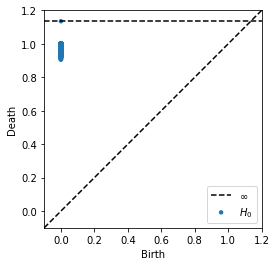

In [13]:
# plot persistence diagram in dimensions 0 and 1 (on same axes).
# points at infinity (homology groups) are plotted on the dotted 
# line which represents the point \infty.
persim.plot_diagrams(rips_lt['dgms'][0])

In [16]:
del NNG

In [22]:
NNGLT = nn_graph.NNGraph()
%time NNGLT.parameter_graph(model_lt, alnt.param_info, (1,1,28,28), ignore_zeros=True)

Layer: Conv1
Layer: MaxPool1
Layer: Conv2
Layer: MaxPool2
Layer: Conv3
Layer: Conv4
Layer: Conv5
Layer: MaxPool3
Layer: Linear1
Layer: Linear2
Layer: Linear3
CPU times: user 2min 32s, sys: 32.6 s, total: 3min 4s
Wall time: 5min 57s


In [23]:
%time rips_lt2 = ripser(scipy.sparse.csr_matrix(NNGLT.get_adjacency()), distance_matrix=True, maxdim=1)
rips_lt2

CPU times: user 24.2 s, sys: 2.44 s, total: 26.6 s
Wall time: 27.9 s


{'dgms': [array([[0.        , 0.90565455],
         [0.        , 0.90669388],
         [0.        , 0.90852445],
         ...,
         [0.        , 1.        ],
         [0.        , 1.        ],
         [0.        ,        inf]]),
  array([[1.0146606 ,        inf],
         [1.01368713,        inf],
         [1.01339567,        inf],
         ...,
         [0.94325763,        inf],
         [0.94262832,        inf],
         [0.94133192,        inf]])],
 'cocycles': [[], []],
 'num_edges': 2018901,
 'dperm2all': <34164x34164 sparse matrix of type '<class 'numpy.float64'>'
 	with 4037802 stored elements in Compressed Sparse Row format>,
 'idx_perm': array([    0,     1,     2, ..., 34161, 34162, 34163]),
 'r_cover': 0.0}

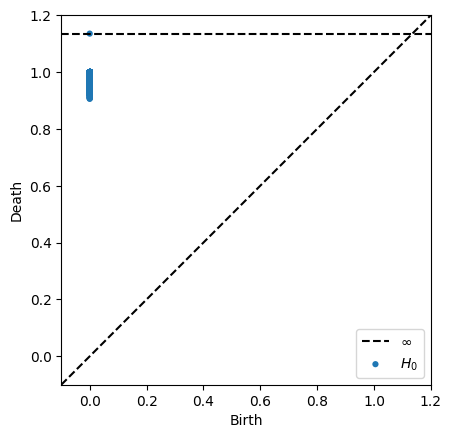

In [30]:
persim.plot_diagrams(rips_lt2['dgms'][0])

In [38]:
(rips_lt2['dgms'][0][-10000:] == rips_lt['dgms'][0][-10000:]).all()

True